In [3]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [4]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [6]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        print(env.action_space.sample())
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        # TODO: Implement this!
        if a:
#             state_action = np.array([s, a])
            return self.models[a].predict([self.featurize_state(s)])
        else:
            predictions = []
            for model in self.models:
#                 state_action = np.array([s, i])
                predictions.append(model.predict([self.featurize_state(s)]))
            return np.array(predictions)
                
#         return 0 if a else np.zeros(env.action_space.n)
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
#         state_action = np.array([s, a])
        self.models[a].partial_fit([self.featurize_state(s)], [y])
        return None

In [7]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        # this shows how to predict
        q_values = estimator.predict(observation)
#         print('q values pre update', q_values)
        best_action = np.argmax(q_values)
#         print('best action', best_action)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    actions = [i for i in range(0, env.action_space.n)]
    # want to go state, action --> state2, max_action2

    for i_episode in range(num_episodes):
        # The policy we're following
        # pass in epsilon of 0 and therefore always selecting greedily (not epsilon greedily)
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
#         print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        
        initial_observation = env.reset()
        # Goal is to do accurate policy approximation while also improving e-greedy policy to converge
        # on optimal policy.
        # Training data will be <state, action, td target> --> learn from state action pair what 
        # the td target should be. td target is comprised of next state / action
        # so requires taking action / getting second state
        for step in itertools.count():
            # Take E-greedy action, get state-prime
            action_probabilities = policy(initial_observation)
            chosen_action = np.random.choice(actions, 1, p=action_probabilities)[0]
            second_observation, reward, done, info = env.step(chosen_action)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = step
            
            if done:
                print('step {}, chosen {}, obs {}, reward {}, info {}'.format(step, chosen_action, second_observation, reward, info))
                break

            # Determine max-q for state-prime, all action options.
            # Update model in direction of the td target.
            action_values = estimator.predict(second_observation)
            best_value = np.amax(action_values)
            td_target = reward + discount_factor * best_value
            estimator.update(initial_observation, chosen_action, td_target)
            initial_observation = second_observation
    #         print('q values post update {}, best_value {}, td_target {}'.format(action_values, best_value, td_target))        
    
    return stats

In [9]:
actions = [i for i in range(0, env.action_space.n)]
print(actions)

[0, 1, 2]


In [10]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
estimator = Estimator()
stats = q_learning(env, estimator, 100, epsilon=0.0)

1
step 199, chosen 1, obs [-0.49359496 -0.00354347], reward -1.0, info {}
step 199, chosen 0, obs [-0.5300366  -0.00317582], reward -1.0, info {}
step 199, chosen 0, obs [-0.79748989 -0.00115743], reward -1.0, info {}
step 199, chosen 0, obs [-0.45545742 -0.03034526], reward -1.0, info {}
step 199, chosen 1, obs [-0.6631253   0.01481888], reward -1.0, info {}
step 199, chosen 2, obs [-0.4984006   0.01315531], reward -1.0, info {}
step 199, chosen 0, obs [-0.37557399  0.02762641], reward -1.0, info {}
step 199, chosen 2, obs [-0.38670436  0.02748632], reward -1.0, info {}
step 199, chosen 2, obs [-0.91528388  0.00302298], reward -1.0, info {}
step 199, chosen 1, obs [-0.7842855   0.02061684], reward -1.0, info {}
step 199, chosen 1, obs [-0.21107682 -0.02640021], reward -1.0, info {}
step 199, chosen 1, obs [-0.9620402  -0.00619261], reward -1.0, info {}
step 199, chosen 2, obs [-0.10684091 -0.01277616], reward -1.0, info {}
step 199, chosen 1, obs [-0.86233848 -0.00768344], reward -1.0

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


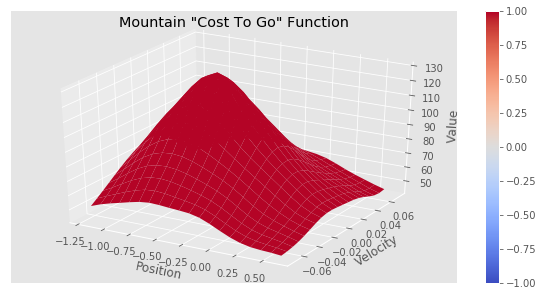

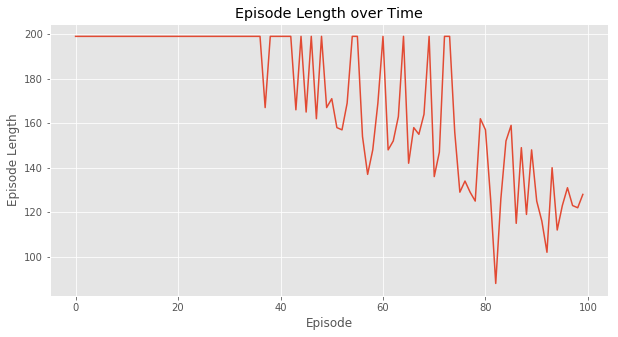

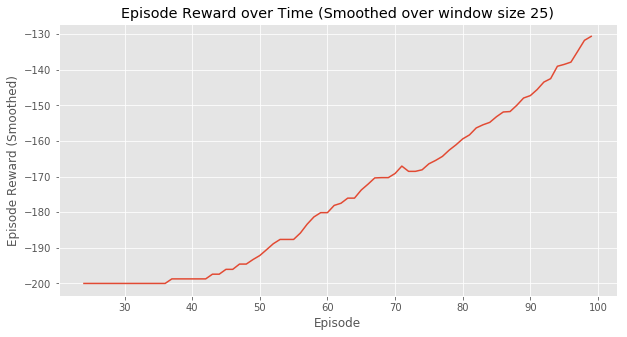

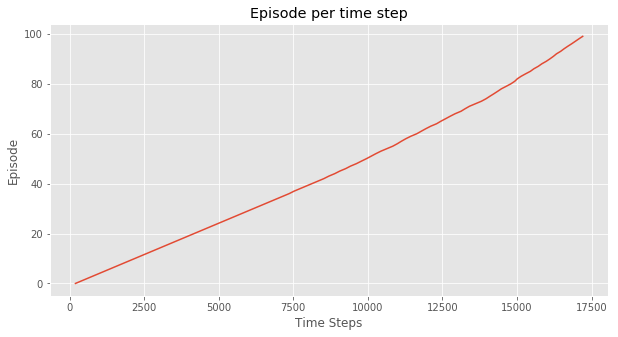

(<matplotlib.figure.Figure at 0x111cd9860>,
 <matplotlib.figure.Figure at 0x113d465f8>)

In [11]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)